### Imports

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle
import time
from array import array
from scipy.interpolate import interp1d
import multiprocessing
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
import itertools
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
statMethod = rt.TEfficiency.kFCP

# Load data

In [4]:
trigger = 'HLT_Mu7_IP4'
# trigger = 'HLT_Mu9_IP6'
# trigger = 'HLT_Mu12_IP6'
version='v8base'

In [5]:
webFolder = '/storage/user/ocerri/public_html/BPH_RDst/triggerScaleFactors/'+version
print webFolder

/storage/user/ocerri/public_html/BPH_RDst/triggerScaleFactors/v8base


In [6]:
effLoc = '../data/calibration/triggerScaleFactors/'+ trigger
finRD = rt.TFile(effLoc + '_RD_{}.root'.format(version), 'READ')
effRD = finRD.Get('eff_' + trigger)
effRD.SetStatisticOption(statMethod)
finMC = rt.TFile(effLoc + '_MC_{}.root'.format(version), 'READ')
effMC = finMC.Get('eff_' + trigger)
effMC.SetStatisticOption(statMethod)

In [7]:
def recomputeEffErr(idx, pEff):
    nT = pEff.GetTotalHistogram().GetBinContent(idx)
    nP = pEff.GetPassedHistogram().GetBinContent(idx)
    eff = nP/float(nT)
    effUnc = np.sqrt((1-eff)*eff/nT)
    print 'Crude approx: {:.3f} +/- {:.3f}'.format(eff, effUnc)
    
    effTest = rt.TEfficiency('effTest', 'effTest;x;#epsilon', 1, 0, 1)
    effTest.SetStatisticOption(statMethod)
    effTest.SetTotalEvents(1, int(nT))
    effTest.SetPassedEvents(1, int(nP))
    print 'Recomputing...'
    print 'eff: {:.3f} -{:.3f} / + {:.3f}'.format(effTest.GetEfficiency(1),
                                                  effTest.GetEfficiencyErrorLow(1),
                                                  effTest.GetEfficiencyErrorUp(1))
    print '\n'
    return 0.5*(effTest.GetEfficiencyErrorLow(1) + effTest.GetEfficiencyErrorUp(1))

# Compute SF

In [8]:
hSF = effRD.GetCopyPassedHisto()
hSF.SetNameTitle('hSF_' + trigger, 'Scale factors for ' + trigger)
hSF.SetXTitle('Muon p_{T} [GeV]')
hSF.SetYTitle('Muon #sigma_{d_{xy}}/ d_{xy} (IP)')
hSF.SetZTitle('Muon #eta')
hSF.Reset()

In [9]:
for ix, iy, iz in itertools.product(range(1, hSF.GetNbinsX()+1), range(1, hSF.GetNbinsY()+1), range(1, hSF.GetNbinsZ()+1)):
    idx = hSF.GetBin(ix, iy, iz)
    if effMC.GetEfficiency(idx) == 0 or effRD.GetEfficiency(idx) == 0:
        s = 'Eff = 0 at [{}, {}, {}]'.format(ix, iy, iz)
        if effMC.GetEfficiency(idx) == 0:
            s += ' (MC)'
        if effRD.GetEfficiency(idx) == 0:
            s += ' (data)'
        print s
        hSF.SetBinContent(idx, 0.99)
        hSF.SetBinError(idx, 0.05)
        continue
    
    sf = effRD.GetEfficiency(idx)/effMC.GetEfficiency(idx)
    
    errRD = 0.5*(effRD.GetEfficiencyErrorLow(idx) + effRD.GetEfficiencyErrorUp(idx))
    if np.isnan(errRD):
        print 'nan RD uncertainty at [{}, {}, {}]'.format(ix, iy, iz)
        print 'Eff RD = {:.3f} -{:.3f} / +{:.3f}'.format(effRD.GetEfficiency(idx), 
                                                         effRD.GetEfficiencyErrorLow(idx), 
                                                         effRD.GetEfficiencyErrorUp(idx))
        errRD = recomputeEffErr(idx, effRD)
        
    if errRD > 0.1:
        print ix, iy, iz, errRD
    errRD /= effRD.GetEfficiency(idx)
    
    errMC = 0.5*(effMC.GetEfficiencyErrorLow(idx) + effMC.GetEfficiencyErrorUp(idx))
    if np.isnan(errMC):
        print 'nan MC uncertainty at [{}, {}, {}]'.format(ix, iy, iz)
        print 'Eff MC = {:.3f} -{:.3f} / +{:.3f}'.format(effMC.GetEfficiency(idx), 
                                                         effMC.GetEfficiencyErrorLow(idx), 
                                                         effMC.GetEfficiencyErrorUp(idx))
        errMC = recomputeEffErr(idx, effMC)
    if errMC > 0.1:
        print ix, iy, iz, errMC
    errMC /= effMC.GetEfficiency(idx)
    
    err_sf = sf*np.hypot(errMC, errRD)
    
    pt = hSF.GetXaxis().GetBinCenter(ix)
    if err_sf > 0.3 and pt > 12:
        hSF.SetBinContent(idx, 0.99)
        hSF.SetBinError(idx, 0.05)
    elif sf > 10 or sf < 0.01:
        hSF.SetBinContent(idx, 0)
        hSF.SetBinError(idx, 0)
    else:
        hSF.SetBinContent(idx, sf)
        hSF.SetBinError(idx, err_sf)

fSF = rt.TFile(effLoc + '_SF_{}.root'.format(version), 'RECREATE')
hSF.Write()
fSF.Close()

Eff = 0 at [1, 1, 1] (MC) (data)
Eff = 0 at [1, 2, 1] (MC) (data)
Eff = 0 at [1, 2, 2] (data)
Eff = 0 at [1, 4, 1] (MC)


To retrieve the SF value:

        ix = hSF.GetXaxis().FindBin(pt)
        iy = hSF.GetYaxis().FindBin(sigdxy)
        iz = hSF.GetZaxis().FindBin(abs(eta))
        w = hSF.GetBinContent(ix, iy, iz)

# Plot the SF

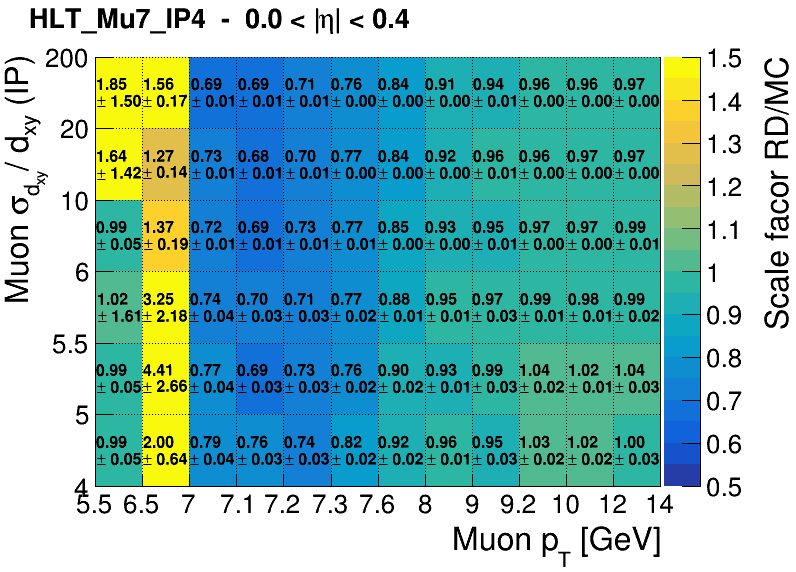

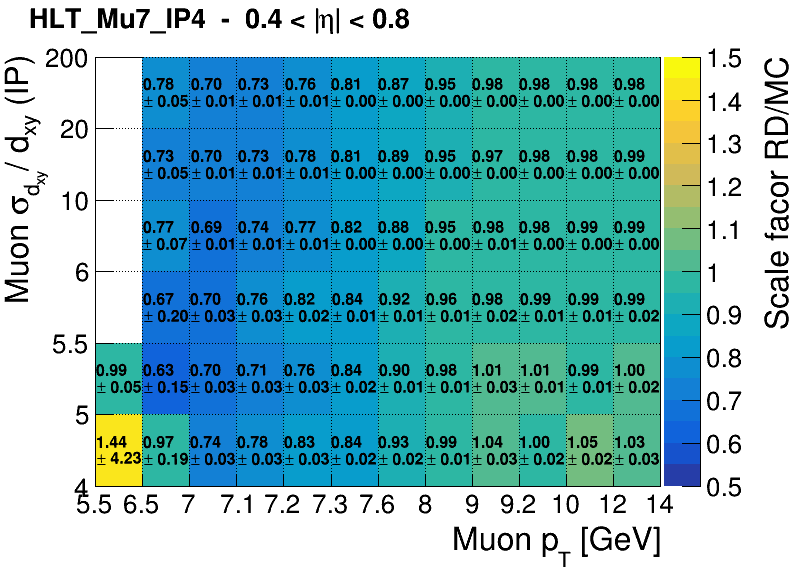

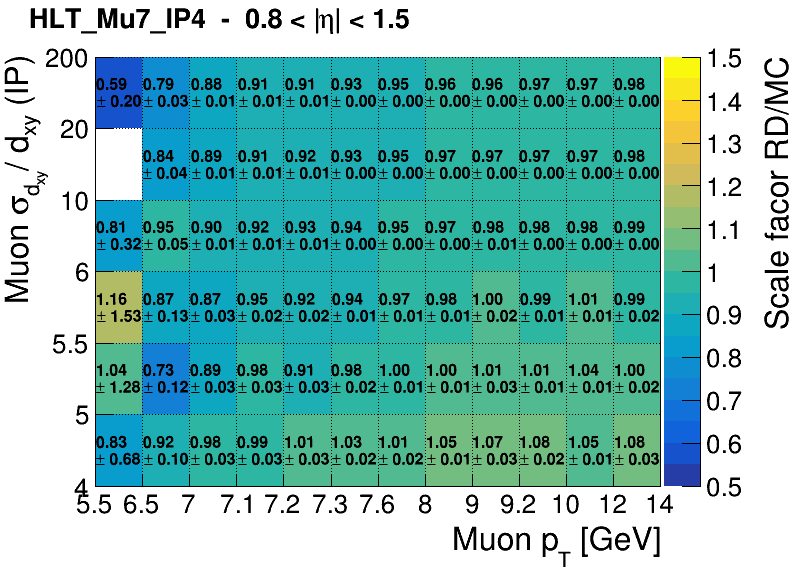

In [10]:
outCanvases = []
rt.gStyle.SetOptTitle(1)
rt.gStyle.SetTitleFillColor(0)
rt.gStyle.SetTitleBorderSize(0)
nx = hSF.GetNbinsX()
ny = hSF.GetNbinsY()

rt.gStyle.SetPaintTextFormat('.2f')
for iz in range(1, hSF.GetNbinsZ()+1):
    minEta = hSF.GetZaxis().GetBinCenter(iz) - 0.5*hSF.GetZaxis().GetBinWidth(iz)
    maxEta = hSF.GetZaxis().GetBinCenter(iz) + 0.5*hSF.GetZaxis().GetBinWidth(iz)
    title = '{}  -  {:.1f} < |#eta| < {:.1f}'.format(trigger, minEta, maxEta)
    
    h2 = rt.TH2D('h'+str(iz), title, nx, 0, nx, ny, 0, ny)
    h2.SetXTitle(hSF.GetXaxis().GetTitle())
    h2.SetYTitle(hSF.GetYaxis().GetTitle())
    h2.SetZTitle('Scale facor RD/MC')

    for iy in range(1, hSF.GetNbinsY()+1):
        for ix in range(1, hSF.GetNbinsX()+1):
            h2.SetBinContent(ix, iy, hSF.GetBinContent(ix, iy, iz))
            idx = hSF.GetBin(ix, iy, iz)
            h2.SetBinError(h2.GetBin(ix, iy), hSF.GetBinError(idx))
    h2.SetMarkerSize(1.5)
    h2.GetZaxis().SetRangeUser(0.5, 1.5)
    h2.GetYaxis().SetTitleOffset(0.9)
    h2.GetXaxis().SetTitleOffset(1.1)
    c = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'texte same'], tag=str(iz))
    c.SetTopMargin(0.1)
    c.SetBottomMargin(0.15)
    c.SetLeftMargin(0.12)
    c.SetRightMargin(0.17)
    
    ax = h2.GetYaxis()
    ax.SetNdivisions(-ny)
    for i in range(ny+2):
        l = hSF.GetYaxis().GetBinCenter(i) + 0.5*hSF.GetYaxis().GetBinWidth(i)
        if i == 0:
            l = hSF.GetYaxis().GetBinCenter(1) - 0.5*hSF.GetYaxis().GetBinWidth(1)            
        ax.ChangeLabel(i+1, -1, -1, -1, -1, -1, '{0:g}'.format(l))
    
    ax = h2.GetXaxis()
    ax.SetNdivisions(-nx)
    for i in range(nx+2):
        l = hSF.GetXaxis().GetBinCenter(i) + 0.5*hSF.GetXaxis().GetBinWidth(i)
        if i == 0:
            l = hSF.GetXaxis().GetBinCenter(1) - 0.5*hSF.GetXaxis().GetBinWidth(1)            
        ax.ChangeLabel(i+1, -1, -1, -1, -1, -1, '{0:g}'.format(l))
    
    imgLoc = '../data/calibration/triggerScaleFactors/figSF/'
    c.SaveAs(imgLoc + trigger + '_eta{}_{}.png'.format(iz-1, version))
    c.SaveAs(webFolder + '/scaleFactors_'+ trigger + '_eta{}_{}.png'.format(iz-1, version))
    c.SetGrid()
    outCanvases.append([c, h2])